In [38]:
import os
import uuid
from typing import TypedDict, Annotated, Optional, Literal, Any, List, AsyncGenerator
from IPython.display import display, Image

from langgraph.checkpoint.postgres.aio import AsyncPostgresSaver
from langgraph.graph.state import CompiledStateGraph
from psycopg_pool import AsyncConnectionPool
from pydantic import BaseModel
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END
from langgraph.graph import add_messages
from langgraph.types import interrupt, Command
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate

from dto.response.grades import GradeResponseBase
from dto.response.matrix_chats import MessageDict

load_dotenv()
db_url = os.getenv("PG_VECTOR_DATABASE_URL")

LITE_LLM_API_KEY = os.getenv("OPENAI_API_KEY")
# LITE_LLM_URL = os.getenv("OPENAI_BASE_URL")
# LITE_MODEL = os.getenv("OPENAI_MODEL")

# model = ChatOpenAI(model=LITE_MODEL, api_key=LITE_LLM_API_KEY, base_url=LITE_LLM_URL)
model = ChatOpenAI(model="gpt-4o", api_key=LITE_LLM_API_KEY, streaming=True, verbose=True)


class AmbiguousStdOutput(BaseModel):
    is_ambiguous: bool
    question: str


def convert_msg_dict_to_langgraph_format(
    msgs: List[MessageDict],
) -> List[AIMessage | HumanMessage | SystemMessage]:
    langchain_msgs: List[AIMessage | HumanMessage | SystemMessage] = []
    for msg in msgs:
        if msg.msg_type == "ai":
            langchain_msgs.append(AIMessage(msg.message))
        elif msg.msg_type == "human":
            langchain_msgs.append(HumanMessage(msg.message))
        elif msg.msg_type == "system":
            langchain_msgs.append(SystemMessage(msg.message))

    return langchain_msgs


class SpellcheckBase(BaseModel):
    spelling: str
    corrected_spelling: str
    correction_applied: bool


class ReasonerOutputBase(BaseModel):
    classification: str
    classification_explanation: str
    certainty_level: int


class ReasonerState(TypedDict):
    grades: List[GradeResponseBase]
    messages: Annotated[list, add_messages]
    spellcheck_response: Optional[SpellcheckBase]
    reasoner_response: Optional[ReasonerOutputBase]
    interrupt_state: dict[str, str]
    is_ambiguous: bool


class ClassifierState(TypedDict):
    grades: List[GradeResponseBase]
    msgs: Annotated[list, add_messages]
    finished_state: Optional[str]
    interrupt_state: dict[str, str]


classifier_builder = StateGraph(ClassifierState)


async def reasoner(state: ClassifierState) -> ClassifierState:
    message = ChatPromptTemplate.from_messages(
        (
            "system",
            """
            Based on the user question you need to categorize into one of the following categories:
            {categories}
            Respond only with the category recognized!
            """,
        )
    )
    msg = message.format(categories=state["grades"])
    model_structured = model.with_structured_output(ReasonerOutputBase)
    response = await model_structured.ainvoke(state["msgs"] + [msg])
    return {
        "msgs": [AIMessage(response.classification)],
        "finished_state": None,
        "grades": state["grades"],
        "interrupt_state": {},
    }


async def reflect(state: ClassifierState) -> ClassifierState:
    input_val = state["msgs"][-2].content
    predicted_state = state["msgs"][-1].content
    prompt_template = ChatPromptTemplate.from_template(
        """
        You are an reviewing user submission categorization of the answer of expertise in a particular subject.
        You are provided the available expertise categories to which you need to categorize into.
        Critique the prediction if you think it's incorrect!
        If you agree with correct prediction respond with exactly "finish" without any explanations!
        If you find the categorization inconclusive or not indicative in any way of the user message respond with exactly "human"!
        Expertise categories:
        {categories}
        Users message: {msg}
        Predicted user expertise: {state}
        """
    )
    prompt = await prompt_template.ainvoke(
        {"state": predicted_state, "msg": input_val, "categories": state["grades"]}
    )
    response = model.invoke(prompt)
    return {
        "msgs": [HumanMessage(response.content)],
        "finished_state": None,
        "grades": state["grades"],
        "interrupt_state": {},
    }


async def correct_found(
    state: ClassifierState,
) -> Literal["reasoner", "human", "finish"]:
    if state["msgs"][-1].content == "finish":
        return "finish"
    elif state["msgs"][-1].content == "human":
        return "human"
    return "reasoner"


async def finish(state: ClassifierState) -> ClassifierState:
    finished_state = state["msgs"][-2].content
    return {
        "msgs": state["msgs"],
        "finished_state": finished_state,
        "grades": state["grades"],
        "interrupt_state": {},
    }


async def human(state: ClassifierState) -> ClassifierState:
    interrupt_val = {
        "answer_to_revisit": state["msgs"][-2].content,
    }
    value = interrupt(
        interrupt_val,
    )
    return {
        "msgs": [AIMessage(value)],
        "finished_state": state["finished_state"],
        "grades": state["grades"],
        "interrupt_state": interrupt_val,
    }

classifier_builder.add_node("reasoner", reasoner)
classifier_builder.add_node("reflect", reflect)
classifier_builder.add_node("finish", finish)
classifier_builder.add_node("human", human)
classifier_builder.add_edge(START, "reasoner")
classifier_builder.add_edge("reasoner", "reflect")
classifier_builder.add_conditional_edges("reflect", correct_found)
classifier_builder.add_edge("reflect", "finish")
classifier_builder.add_edge("human", "finish")
classifier_builder.add_edge("finish", END)

classify = classifier_builder.compile()

builder = StateGraph(ReasonerState)


async def spellchecker(state: ReasonerState) -> ReasonerState:
    prompt_template = ChatPromptTemplate.from_template(
        """
        Spellcheck the users input. Do not explain yourself or add any other content!
        Respond only with the corrected full version of text. If no corrections have happened pass original text!

        Input: {input}
        """
    )
    model_structured = model.with_structured_output(SpellcheckBase)
    prompt = await prompt_template.ainvoke({"input": state["messages"][0].content})
    response = model_structured.invoke(prompt)
    print(f"SPELLCHECKER STATE {state}")
    return {
        "grades": state["grades"],
        "messages": state["messages"],
        "spellcheck_response": response,
        "reasoner_response": None,
        "interrupt_state": {},
        "is_ambiguous": False,
    }


async def ambiguity_resolver(state: ReasonerState) -> ReasonerState:
    message = ChatPromptTemplate.from_messages(
        (
            "system",
            """
            You are responsible to understand is there any ambiguity in answer from the user?
            User was asked to provide an answer about their expertise in the categories.
            If the answer is ambiguous please respond that this is not related with the question
            and reiterate the question

            Categories: {categories}
            Answer: {answer}
            """,
        )
    )
    print(f"AMBIGUITY RESOLVER STATE {state}")
    structured_output_model = model.with_structured_output(AmbiguousStdOutput)
    msg = message.format(categories=state["grades"], answer=state["messages"][-1].content)
    response = await structured_output_model.ainvoke(state["messages"] + [msg])
    print(f"ambiguity_resolver response {response}")
    return {
        "grades": state["grades"],
        "messages": [AIMessage(response.question)],
        "spellcheck_response": response,
        "reasoner_response": None,
        "interrupt_state": {},
        "is_ambiguous": response.is_ambiguous,
    }


async def next_step(state: ReasonerState) -> Literal["deeply_classify", "ask_clarification"]:
    print("NEXT STEP", state)
    if state["is_ambiguous"]:
        return "ask_clarification"
    return "deeply_classify"


async def ask_clarification(state: ReasonerState) -> ReasonerState:
    interrupt_val = {
        "answer_to_revisit": state["messages"][-2].content,
    }
    interrupt_msg = interrupt(interrupt_val)
    return {
        "grades": state["grades"],
        "messages": [AIMessage(interrupt_msg)],
        "spellcheck_response": state["spellcheck_response"],
        "reasoner_response": None,
        "interrupt_state": interrupt_val,
        "is_ambiguous": response.is_ambiguous,
    }


async def deeply_classify(state: ReasonerState) -> ReasonerState:
    async for class_chunk in classify.astream(
        {"msgs": state["messages"], "finished_state": None, "grades": state["grades"]}
    ):
        if class_chunk["finished_state"] is not None:
            msg = class_chunk["finished_state"]

    return {
        "grades": state["grades"],
        "messages": [],
        "spellcheck_response": state["spellcheck_response"],
        "reasoner_response": state["reasoner_response"],
        "interrupt_state": {},
        "is_ambiguous": state["is_ambiguous"],
    }


async def reasoner(state: ReasonerState) -> ReasonerState:
    prompt_template = ChatPromptTemplate.from_template(
        """
        Summarize the conversation and show the finalized categorization!
        Use one of these categories, labels only, do not display the entire object:
        {grades}
        Do not explain yourself and prolong the conversation!
        """
    )
    prompt = prompt_template.invoke({"grades": state["grades"]})
    response = model.invoke(state["messages"] + [HumanMessage(prompt.to_string())])
    return {
        "grades": state["grades"],
        "messages": [AIMessage(response.content)],
        "spellcheck_response": state["spellcheck_response"],
        "reasoner_response": state["reasoner_response"],
        "interrupt_state": {},
        "is_ambiguous": state["is_ambiguous"]
    }


async def human(state: ReasonerState) -> ReasonerState:
    return {
        "grades": state["grades"],
        "messages": [],
        "spellcheck_response": state["spellcheck_response"],
        "reasoner_response": state["reasoner_response"],
        "interrupt_state": {},
        "is_ambiguous": state["is_ambiguous"]
    }


builder.add_node("spellchecker", spellchecker)
builder.add_node("ambiguity", ambiguity_resolver)
builder.add_node("ask_clarification", ask_clarification)
builder.add_node("deeply_classify", deeply_classify)
builder.add_node("reasoner", reasoner)
builder.add_edge(START, "spellchecker")
builder.add_edge("spellchecker", "ambiguity")
builder.add_conditional_edges("ambiguity", next_step)
builder.add_edge("ask_clarification", "spellchecker")
builder.add_edge("deeply_classify", "reasoner")
builder.add_edge("reasoner", END)

full_graph = builder.compile()


async def get_graph() -> AsyncGenerator[CompiledStateGraph, Any]:
    async with AsyncConnectionPool(db_url) as conn:
        checkpointer = AsyncPostgresSaver(
            conn=conn,
        )
        graph = builder.compile(checkpointer=checkpointer)
        yield graph


async def reasoner_run(
    thread_id: uuid.UUID, msgs: List[MessageDict], grades: List[GradeResponseBase]
):
    async for graph in get_graph():
        config = {"configurable": {"thread_id": thread_id}}
        state = await graph.aget_state(config)
        messages_to_send = []
        grades_to_send = []

        if len(state.values) == 0:
            messages_to_send = convert_msg_dict_to_langgraph_format(msgs)
            grades_to_send = grades
        else:
            messages_to_send = state.values["messages"]
            grades_to_send = state.values["grades"]
        print("MSGS TO SEND:", messages_to_send)
        print("GRADS TO SEND:", grades_to_send)
        response = await graph.ainvoke(
            {
                "messages": messages_to_send,
                "grades": grades_to_send,
            },
            config,
        )
        print("GRAPH RESPONSE:", response)
        interrupt_happened = False
        interrupt_value = ""
        if "__interrupt__" in response:
            interrupt_happened = True
            interrupt_value = response["__interrupt__"][0].value

        display(Image(graph.get_graph().draw_mermaid_png()))
        return {
            "interrupt_happened": interrupt_happened,
            "interrupt_value": interrupt_value,
            "message": response["messages"][-1].content,
        }

    return None


async def run_interrupted(thread_id: uuid.UUID, unblock_value: str):
    async for graph in get_graph():
        config = {"configurable": {"thread_id": thread_id}}
        state = await graph.aget_state(config)
        unblock_response = await graph.ainvoke(
            Command(resume=unblock_value), config=config
        )
        print("FULL UNBLOCKED RESPONSE:", unblock_response)

STARTING TESTING
MSGS TO SEND: [AIMessage(content='\n        Expertise in Cryptography\n        Welcome, Jessica! In this discussion, we will explore your expertise in Cryptography, which focuses on implementing encryption, hashing, and secure communication protocols. Understanding the appropriate expertise level is crucial for your learning and application in the field.\n\n        We offer various expertise grades to help you identify where you stand or where you want to grow:\n\n        Not Informed - Basic understanding of the subject.\n        Informed Basics - Familiarity with fundamental concepts.\n        Informed in Details - Comprehensive knowledge of the topic.\n        Practice and Lab Examples - Practical experience and demonstration.\n        Production Maintenance - Hands-on experience in maintaining production systems.\n        Production from Scratch - Ability to build production systems from the ground up.\n        Educator/Expert - Mastery of the subject, capable of t

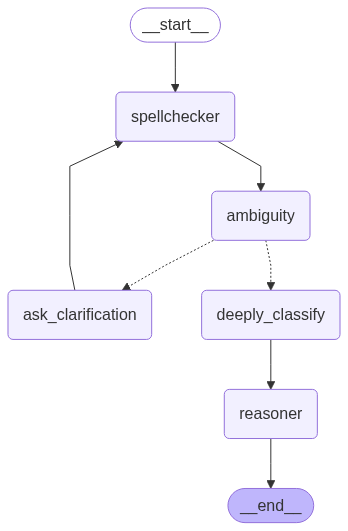

RESULT: {'interrupt_happened': True, 'interrupt_value': {'answer_to_revisit': '\n        bla bla bla\n        '}, 'message': 'Thank you for your response! However, it seems like your answer was not directly related to the question about your expertise level in Cryptography.\n\nCould you please select from the following categories to describe your level of expertise?\n\n1. Not Informed\n2. Informed Basics\n3. Informed in Details\n4. Practice and Lab Examples\n5. Production Maintenance\n6. Production from Scratch\n7. Educator/Expert\n\nYour input is valuable, so feel free to elaborate on your choice if needed!'}


In [39]:

import asyncio

grades: List[GradeResponseBase] = [
    GradeResponseBase(
        id=1,
        label="Not Informed",
        value=1
    ),
    GradeResponseBase(
        id=2,
        label="Informed Basics",
        value=2
    ),
    GradeResponseBase(
        id=3,
        label="Informed in Details",
        value=3
    ),
    GradeResponseBase(
        id=4,
        label="Practice and Lab Examples",
        value=4
    ),
    GradeResponseBase(
        id=5,
        label="Production Maintenance",
        value=5
    ),
    GradeResponseBase(
        id=6,
        label="Production from Scratch",
        value=6
    ),
    GradeResponseBase(
        id=7,
        label="Educator/Expert",
        value=7
    ),
]

msgs: List[MessageDict] = [
    MessageDict(
        msg_type="ai",
        message="""
        Expertise in Cryptography
        Welcome, Jessica! In this discussion, we will explore your expertise in Cryptography, which focuses on implementing encryption, hashing, and secure communication protocols. Understanding the appropriate expertise level is crucial for your learning and application in the field.

        We offer various expertise grades to help you identify where you stand or where you want to grow:

        Not Informed - Basic understanding of the subject.
        Informed Basics - Familiarity with fundamental concepts.
        Informed in Details - Comprehensive knowledge of the topic.
        Practice and Lab Examples - Practical experience and demonstration.
        Production Maintenance - Hands-on experience in maintaining production systems.
        Production from Scratch - Ability to build production systems from the ground up.
        Educator/Expert - Mastery of the subject, capable of teaching others.
        Select the expertise level that resonates with your current understanding or desired growth in Cryptography, and let’s enhance your skills!
        """
    ),
    MessageDict(
        msg_type="human",
        message="""
        bla bla bla
        """
    )
]

def completed_task(result):
    print("COMPLETED TASK:", result.result())

async def main():
    # Get the current running loop
    loop = asyncio.get_running_loop()
    print("STARTING TESTING")
    result = await reasoner_run(uuid.uuid4(), msgs, grades)
    print("RESULT:", result)
    return result

result = await main()

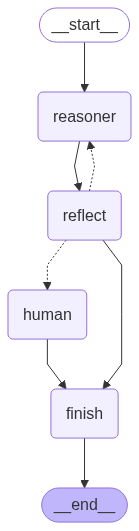

In [3]:
display(Image(classify.get_graph().draw_mermaid_png()))

In [7]:
for chunk in await classify.ainvoke(
        {
            "msgs": [msg.message for msg in msgs],
            "grades": grades,
        }
):
    print("CHUNK", chunk)

CHUNK grades
CHUNK msgs
CHUNK finished_state
CHUNK interrupt_state


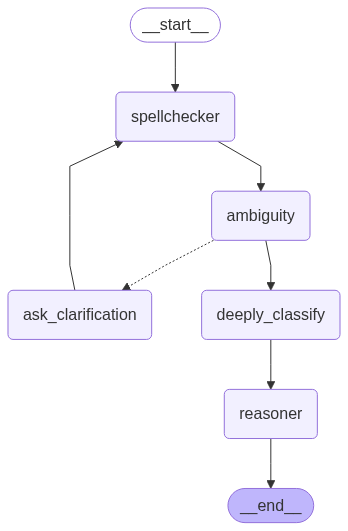

In [31]:
display(Image(full_graph.get_graph().draw_mermaid_png()))
